## Residual Networks Models
### Installation and Import Checks

In [1]:
%pip install tensorflow==2.10
%pip install scikit-learn
%pip install matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
# Machine Learning
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# Plotting
import matplotlib.pyplot as plt

### Optional: GPU Acceleration Check
Checks Tensorflow Version and GPU detection. 
If GPU detected, output should be something like "Num GPUs Available:  1"

In [3]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices()
print("Physical Devices:", physical_devices)

TensorFlow version: 2.10.0
Num GPUs Available:  1
Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load and Split Prepared Data
Loads in preprocessed data from the ./prepared_data directory for x and y features. Splits for training and testing 80/20 ratio

In [4]:
# Load the data
x_input = np.load('prepared_data/x_input_combined.npy')
y_output = np.load('prepared_data/y_output_combined.npy')

# Ensure y is one-hot encoded if not already
y_output = to_categorical(y_output, num_classes=4)  # Assuming there are 4 classes
# Resizes images to 224 x 224 for optimal size for VGG models
x_input_resized = np.array([tf.image.resize(image, (224, 224)).numpy() for image in x_input])

# Split the data into training and testing sets
x_input_train, x_input_test, y_output_train, y_output_test = train_test_split(x_input_resized, y_output, test_size=0.2, random_state=42)

# Printing Dimensions of data
print(f'X Training Data\nNumber of Rows: {x_input_train.shape[0]}\nPixel Dimensions: {x_input_train.shape[1]}x{x_input_train.shape[2]}x{x_input_train.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_train.shape[0]}\nNumber of Classes: {y_output_train.shape[1]}\n')
print(f'X Testing Data\nNumber of Rows: {x_input_test.shape[0]}\nPixel Dimensions: {x_input_test.shape[1]}x{x_input_test.shape[2]}x{x_input_test.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_test.shape[0]}\nNumber of Classes: {y_output_test.shape[1]}')

X Training Data
Number of Rows: 1536
Pixel Dimensions: 224x224x3

Y Training Data
Number of Rows: 1536
Number of Classes: 4

X Testing Data
Number of Rows: 384
Pixel Dimensions: 224x224x3

Y Training Data
Number of Rows: 384
Number of Classes: 4


### Loading and Defining ResNet Models

In [5]:
# Load the ResNet50 model pre-trained on ImageNet
base_resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the ResNet50 base model
x = base_resnet50_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(3))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(3))(x)
x = Dropout(0.5)(x)
output_layer_resnet50 = Dense(4, activation='softmax')(x)  # 4 classes: no tumor, glioma, meningioma, pituitary

# Define the model
resnet50_brain_tumor_model = Model(inputs=base_resnet50_model.input, outputs=output_layer_resnet50)

# # Freeze the layers of the base model
for layer in base_resnet50_model.layers:
    layer.trainable = False

In [6]:
# # Load the ResNet50 model pre-trained on ImageNet
# base_resnet152_model = ResNet152(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# # Adds global average pooling layer to reduce dimensions of features     
# pooled_output_152 = GlobalAveragePooling2D()(base_resnet152_model.output)
# # Adds a dense lyaer with 1024 neurons using RELU activation function     
# dense_layer_152 = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(pooled_output_152)
# # Add dropout layer with 50% dropout rate for regularization to avoid overfitting 
# dropout_layer_152 = Dropout(0.6)(dense_layer_152)
# # Add final output layer with four neurons corresponding to four classes with activation as softmax to predict probability of each class
# output_layer_152 = Dense(4, activation='softmax')(dropout_layer_152)  # 4 classes: no tumor, glioma, meningioma, pituitary

# # Define the model
# resnet152_brain_tumor_model = Model(inputs=base_resnet152_model.input, outputs=output_layer_152)

# # # Freeze the layers of the base model
# # for layer in resnet152_brain_tumor_model.layers:
# #     layer.trainable = False

# # Freeze the initial layers of the base model, unfreeze the top layers for fine-tuning
# for layer in resnet152_brain_tumor_model.layers[:-20]:  # Unfreeze the last 20 layers
#     layer.trainable = False
# for layer in resnet152_brain_tumor_model.layers[-20:]:  # Freeze all the other layers
#     layer.trainable = True

### Training the ResNet Models

In [7]:
# Compile the model
# resnet50_brain_tumor_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
resnet50_brain_tumor_model.compile(optimizer=Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_resnet50 = ModelCheckpoint('model_checkpoints/resnet50_brain_tumor_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_resnet50 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
# trained_resnet50_model = resnet50_brain_tumor_model.fit(train_generator, epochs=50, validation_data=val_generator, 
#                                                 callbacks=[checkpoint_resnet50, early_stopping_resnet50])
trained_resnet50_model = resnet50_brain_tumor_model.fit(x_input_train, y_output_train, epochs=50, validation_data=(x_input_test, y_output_test), 
                                                callbacks=[checkpoint_resnet50, early_stopping_resnet50])

Epoch 1/50
47/48 [============================>.] - ETA: 0s - loss: 1.1688 - accuracy: 0.5160
Epoch 1: val_loss improved from inf to 1.67128, saving model to model_checkpoints\resnet50_brain_tumor_model.keras
48/48 [==============================] - 5s 65ms/step - loss: 1.1703 - accuracy: 0.5150 - val_loss: 1.6713 - val_accuracy: 0.2917
Epoch 2/50
47/48 [============================>.] - ETA: 0s - loss: 0.9822 - accuracy: 0.5951
Epoch 2: val_loss improved from 1.67128 to 1.55954, saving model to model_checkpoints\resnet50_brain_tumor_model.keras
48/48 [==============================] - 3s 53ms/step - loss: 0.9759 - accuracy: 0.5996 - val_loss: 1.5595 - val_accuracy: 0.2917
Epoch 3/50
47/48 [============================>.] - ETA: 0s - loss: 0.9070 - accuracy: 0.6250
Epoch 3: val_loss improved from 1.55954 to 1.52498, saving model to model_checkpoints\resnet50_brain_tumor_model.keras
48/48 [==============================] - 3s 53ms/step - loss: 0.9057 - accuracy: 0.6257 - val_loss: 1.525

In [8]:
# # Compile the model
# # resnet152_brain_tumor_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# resnet152_brain_tumor_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


# # Define callbacks
# checkpoint_resnet152 = ModelCheckpoint('model_checkpoints/resnet152_brain_tumor_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
# early_stopping_resnet152 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# # Train the model
# trained_resnet152_model = resnet152_brain_tumor_model.fit(x_input_train, y_output_train, epochs=50, validation_data=(x_input_test, y_output_test), 
#                                                 callbacks=[checkpoint_resnet152, early_stopping_resnet152])

### Plotting ResNet Model Performances

In [9]:
def plot_model_performance(history, title):
    """
    Plot training and validation loss and accuracy.

    Parameters:
    - history: Keras History object
    - title: str, title of the plot
    """
    # Statistics
    for epoch in range(len(history.history['loss'])):
        print(f"Epoch {epoch + 1}:")
        print(f"  Training Loss: {history.history['loss'][epoch]:.4f}")
        print(f"  Validation Loss: {history.history['val_loss'][epoch]:.4f}")
        print(f"  Training Accuracy: {history.history['accuracy'][epoch]:.4f}")
        print(f"  Validation Accuracy: {history.history['val_accuracy'][epoch]:.4f}")
        print("-" * 40)

    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Fix the accuracy scale from 0 to 1
    plt.legend()

    plt.suptitle(title)
    plt.show()

Epoch 1:
  Training Loss: 1.1703
  Validation Loss: 1.6713
  Training Accuracy: 0.5150
  Validation Accuracy: 0.2917
----------------------------------------
Epoch 2:
  Training Loss: 0.9759
  Validation Loss: 1.5595
  Training Accuracy: 0.5996
  Validation Accuracy: 0.2917
----------------------------------------
Epoch 3:
  Training Loss: 0.9057
  Validation Loss: 1.5250
  Training Accuracy: 0.6257
  Validation Accuracy: 0.3516
----------------------------------------
Epoch 4:
  Training Loss: 0.8217
  Validation Loss: 1.4261
  Training Accuracy: 0.6654
  Validation Accuracy: 0.3698
----------------------------------------
Epoch 5:
  Training Loss: 0.8152
  Validation Loss: 1.2878
  Training Accuracy: 0.6836
  Validation Accuracy: 0.3906
----------------------------------------
Epoch 6:
  Training Loss: 0.7607
  Validation Loss: 1.1932
  Training Accuracy: 0.7018
  Validation Accuracy: 0.4245
----------------------------------------
Epoch 7:
  Training Loss: 0.6969
  Validation Loss: 

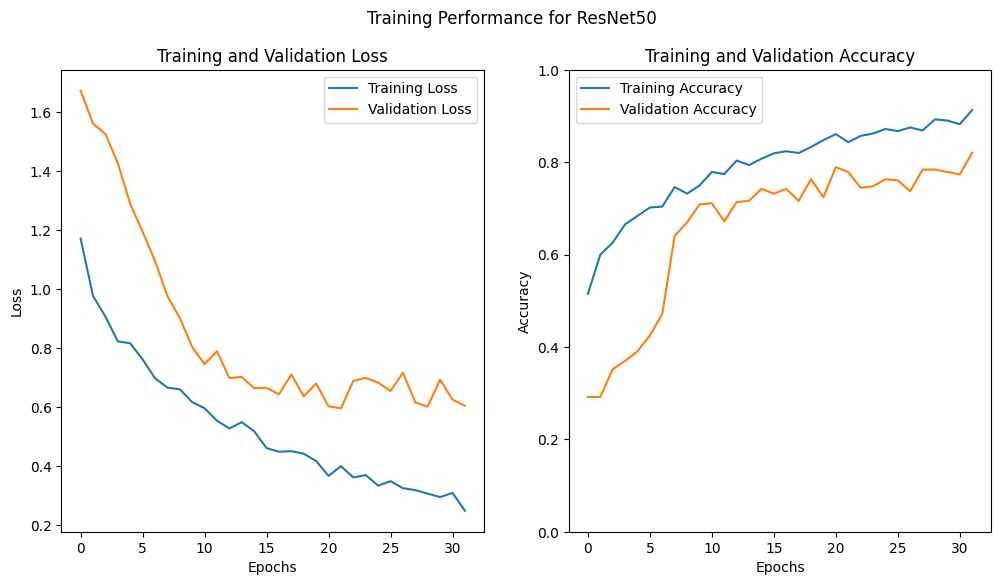

In [10]:
plot_model_performance(trained_resnet50_model, "Training Performance for ResNet50")
# plot_model_performance(trained_resnet152_model, "Training Performance for ResNet152")